# 动手学深度学 7.1节: 深度卷积神经网络(AlexNet) 示例代码

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

定义网络

In [9]:
model = nn.Sequential(
	nn.Conv2d(1, 96, (11, 11), stride=4, padding=1), nn.ReLU(),
	nn.MaxPool2d((3, 3), stride=2),
	nn.Conv2d(96, 256, (5, 5), padding=2), nn.ReLU(),
	nn.MaxPool2d((3, 3), stride=2),
	nn.Conv2d(256, 384, (3, 3), padding=1),
	nn.Conv2d(384, 384, (3, 3), padding=1),
	nn.Conv2d(384, 256, (3, 3), padding=1),
	nn.MaxPool2d((3, 3), stride=2),
	nn.Flatten(),
	nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(0.5),
	nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
	nn.Linear(4096, 10)
)

测试网络

In [10]:
X = torch.randn(1, 1, 224, 224)

for layer in model:
	X = layer(X)
	print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


获取数据集

In [11]:
from utils.data.mnist import  load_data_fashion_mnist

batch_size = 128

train_loader, test_loader = load_data_fashion_mnist(128, resize=224)

训练模型

In [12]:
def train(model:nn.Module, train_loader, test_loader, num_epochs, learning_rate, weight_decay=None, device=None):
	# 参数初始化
	def init_weight(layer):
		if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
			nn.init.xavier_uniform_(layer.weight)
	model.apply(init_weight)

	# 定义损失函数, 优化器
	loss = nn.CrossEntropyLoss()
	optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

	# 绘图
	num_batches = len(train_loader)
	animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train_loss', 'train_acc', 'test_acc'])

	# 确定模型以及数据的位置
	if not device:
		device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
	model.to(device)

	for epoch in range(num_epochs):
		# metric中, 0表示训练的loss, 1表示测试的loss, 2表示测试的准确率
		metric = d2l.Accumulator(3)
		model.train()
		for i, (X, y) in enumerate(train_loader):
			X, y = X.to(device), y.to(device)
			optimizer.zero_grad()
			y_hat = model(X)
			l = loss(y_hat, y)
			l.backward()
			optimizer.step()
			with torch.no_grad():
				metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
			train_l = metric[0] / metric[2]
			train_acc = metric[1] / metric[2]
			if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
				animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
		test_acc = d2l.evaluate_accuracy_gpu(model, test_loader)
		animator.add(epoch + 1, (None, None, test_acc))



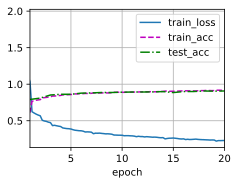

In [13]:
# 定义超参数
lr, num_epoch = 1e-2, 20

train(model, train_loader, test_loader, num_epoch, lr)